# SiebenApp Rendering v3.0

A short SiebenApp rendering history.

* v1.0: use `GraphViz` to render all nodes and draw a picture.
* v2.0: rewrite rendering from scratch using Sugiyama method.
* v2.5: add few custom hacks to Sugiyama method (e.g., enforce width limit).
* v3.0: this approach.


In [2]:
# Some example graph
edges = {
    1: [8, 10, 12, 13],
    2: [5],
    3: [6],
    4: [],
    5: [],
    6: [],
    7: [],
    8: [],
    9: [],
    10: [11],
    11: [3],
    12: [2, 4, 14],
    13: [7, 9],
    14: [],
}

In [3]:
# Rendering defaults
WIDTH = 3

Let's visualize a graph.

In [4]:
import matplotlib.pyplot as plt

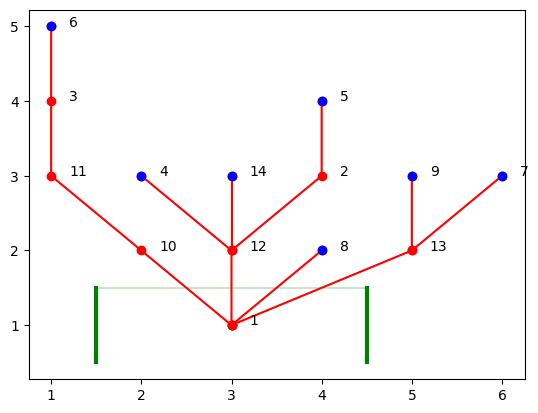

In [5]:
# Tree structure and not-switchable nodes
plt.plot([3, 2, 1, 1, 1], [1, 2, 3, 4, 5], 'ro-')
plt.plot([3, 3, 2], [1, 2, 3], 'ro-')
plt.plot([3, 3], [2, 3], 'ro-')
plt.plot([3, 4, 4], [2, 3, 4], 'ro-')
plt.plot([3, 4], [1, 2], 'ro-')
plt.plot([3, 5, 5], [1, 2, 3], 'ro-')
plt.plot([5, 6], [2, 3], 'ro-')
# Mark switchable nodes
plt.plot([1, 2, 3, 4, 4, 5, 6], [5, 3, 3, 4, 2, 3, 3], 'bo')
# Draw labels
plt.text(3.2, 1, "1"); plt.text(4.2, 3, "2"); plt.text(1.2, 4, "3")
plt.text(2.2, 3, "4"); plt.text(4.2, 4, "5"); plt.text(1.2, 5, "6")
plt.text(6.2, 3, "7"); plt.text(4.2, 2, "8"); plt.text(5.2, 3, "9")
plt.text(2.2, 2, "10"); plt.text(1.2, 3, "11"); plt.text(3.2, 2, "12")
plt.text(5.2, 2, "13"); plt.text(3.2, 3, "14")
# Draw "tube" with width 3
plt.plot([1.5, 1.5], [0.5, 1.5], 'g-', linewidth=3.0)
plt.plot([4.5, 4.5], [0.5, 1.5], 'g-', linewidth=3.0)
plt.plot([1.5, 4.5], [1.5, 1.5], 'g-', linewidth=0.3)
plt.show()

First, we want to place all nodes (goals) onto layers with maximum width of `WIDTH`. We start from `root` and move on edges.

In [12]:
from typing import Dict, List

def tube(edges: Dict[int, List[int]], roots: List[int], layers: List[List[int]]):
    new_layer: List[int] = roots[:WIDTH]
    new_roots: List[int] = roots[len(new_layer):] + [e for n in new_layer for e in edges[n]]
    return new_roots, layers + [new_layer]

In [14]:
r = [1]
l = []

while r:
    r, l = tube(edges, r, l)

l

[[1], [8, 10, 12], [13, 11, 2], [4, 14, 7], [9, 3, 5], [6]]

Let's visualise it as is.

In [26]:
def draw(edges: Dict[int, List[int]], layers: List[List[int]]) -> None:
    xpos: Dict[int, int] = {}
    ypos: Dict[int, int] = {}
    for i, layer in enumerate(layers):
        for j, n in enumerate(layer):
            xpos[n] = j + 1
            ypos[n] = i + 1
    for goal_id, gs in edges.items():
        for g1 in gs:
            plt.plot([xpos[goal_id], xpos[g1]], [ypos[goal_id], ypos[g1]], 'ro-')
        plt.text(xpos[goal_id] + 0.1, ypos[goal_id], str(goal_id))
    switchables = [g for g, gs in edges.items() if not gs]
    xs = [xpos[g] for g in switchables]
    ys = [ypos[g] for g in switchables]
    plt.plot(xs, ys, 'bo')
    plt.draw()

Initial graph version:

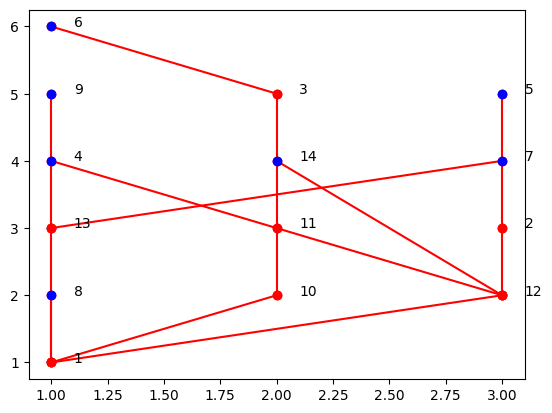

In [27]:
draw(edges, l)

Next step is to find the best possible node placement for each layer. We calculate the 'force' that 'tows' each node to the left or to the right. And then find a node combination with a minimal total force. This step is **NP-full**.

In [ ]:
# [1, x, x] -> {8: 0, 10: 1, 12: 2, 13: 0} -> [0, 1, 2, 0] -> (abs(0) + abs(1) + abs(2) + abs(0), abs(0 + 1 + 2 + 0)) -> (3, 3)
# [x, 1, x] -> {8: -1, 10: 0, 12: 1, 13: -1} -> [-1, 0, 1, -1] -> (abs(-1) + abs(0) + abs(1) + abs(-1), abs(-1 + 0 + 1 -1)) -> (3, 1)
# [x, x, 1] -> {8: -2, 10: -1, 12: 0, 13: -2} -> [-2, -1, 0, -2] -> (abs(-2) + abs(-1) + abs(0) + abs(-2), abs(-2 - 1 + 0 - 2)) -> (5, 5)
#
# (3, 1) < (3, 3) < (5, 5)
# [x, 1, x] is the best position